In [59]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [60]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
        self.r += self.dt*self.v
        self.v += self.dt*self.a
        
        # Euler-Cromer
  #      self.v += self.dt*self.a
  #      self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
        self.PE = 0.5 * self.K * compresion**2
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    def Rebote(self, i):

        pared = 20

        vinv = np.array([1, -1])
        hinv = np.array([-1, 1])
        inv = np.array([hinv, vinv])
        
        pos1 = self.R[i] + np.full(len(self.R[i]), self.radius)
        pos2 = self.R[i] - np.full(len(self.R[i]), self.radius)

        #if (j >= pared for j in pos1).any() or (j  <= -pared for j in pos2).any():   
        if np.any(pos1 >= pared) or np.any(pos2 <= -pared):
            for k in range(len(pos1)):
                if pos1[k] >= pared or pos2[k] <= -pared:
                    self.v = self.v * inv[k]

In [61]:
def GetParticles(N,t):
    
    part = np.linspace(0, N-1, N)
    Particles = []

    for i in part:
        r0 = np.random.uniform(low=-20, high=20, size=2)
        v0 = np.random.uniform(low=-5, high=5, size=2)
        a0 = np.zeros(2)
        p0 = Particle(r0, v0, a0, t, m=1, radius=2, Id=i)
        Particles.append(p0)
    
    return Particles

In [62]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(3,t)

In [63]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].Rebote(it)
            
            
    return Particles

In [64]:
Particles = RunSimulation(t,Particles)
#Particles[0].V

Running simulation: 100%|██████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6363.77 Steps/s]


In [65]:
# Bajamos dimensión de la simulacion
scale = 50
t1 = t[::scale]

<IPython.core.display.Javascript object>


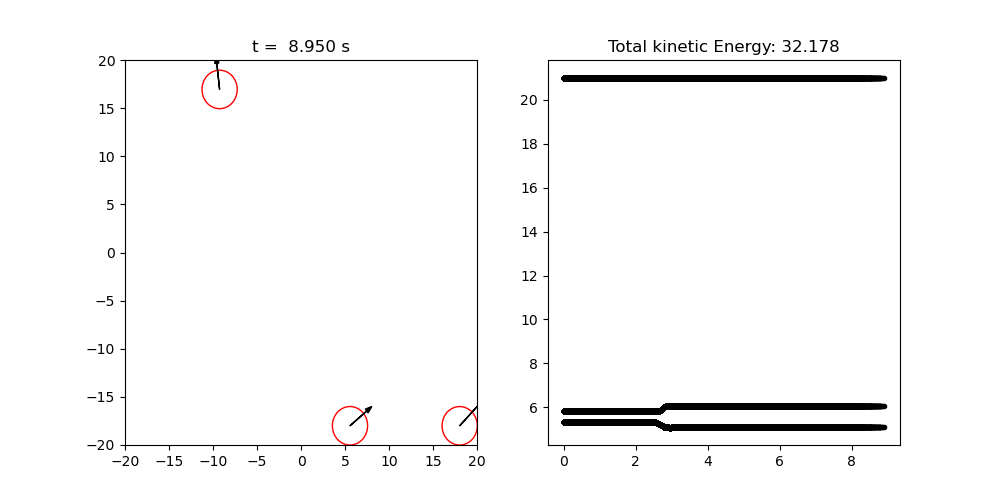

In [66]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [20]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=10, metadata=dict(artist='Me'))
#Animation.save('EsferaDura.mp4', writer=writer_)

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [23]:
MomentumT = Particles[0].GetMomentum(scale)

In [24]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

<IPython.core.display.Javascript object>


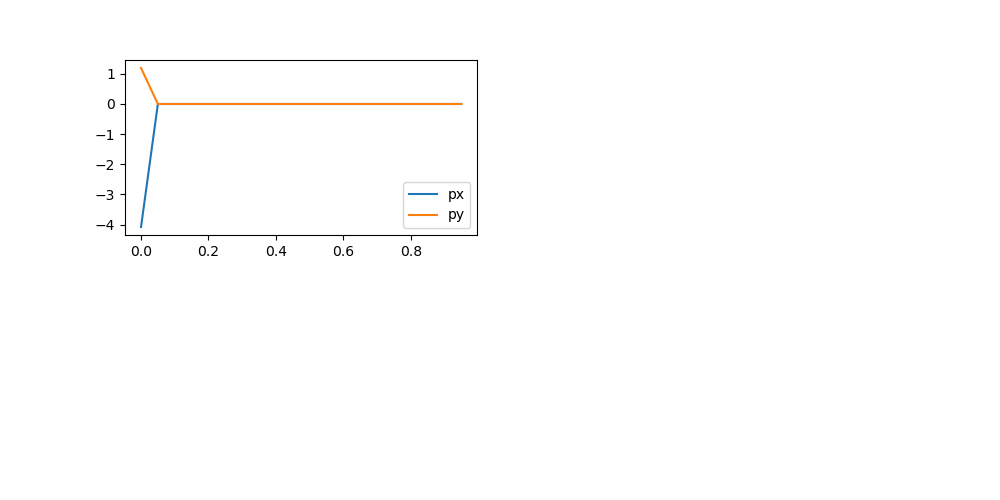

In [25]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()